In [1]:
%cd '/mnt/scratch-lustre/horlaville/clara_limlam/limCode2020-master_clara_2/'

/fs/lustre/scratch/horlaville/clara_limlam/limCode2020-master_clara_2


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u # I use astropy units in everything, very helpful for bookkeeping/debugging

from lim import lim # The base intensity mapping object

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) # Make figures better
#matplotlib.rcParams,update({}'figure.figsize'] = [8,7]
from scipy.ndimage import gaussian_filter
plt.rcParams["mathtext.fontset"] = "dejavuserif"

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\\usepackage{tgheros}\\usepackage{sansmath}\\sansmath'

from mpl_toolkits.axes_grid1 import make_axes_locatable

def own_noise(m, sign, sigm, pix=1.):
    
    '''
    m is the limlam object
    sig is the 3D cube of intensities
    sigm is the noise level
    pix is the pixelization blurring desired. default is 1.
    '''
    
    sm_map = gaussian_filter(sign, [pix, pix, 0])
    noise_sigma  = sigm
    noise_map    = np.random.normal(0, noise_sigma.to(u.Jy/u.sr, equivalencies=u.brightness_temperature(m.nuObs)).value, sign.shape)
    # print(noise_sigma.to(u.Jy/u.sr).value)
    sm_noise_map = sm_map + noise_map
    
    return sm_noise_map

In [3]:
# Initialize LineModel with default model
m = lim()
m_cii = lim('Lichen_v4', doSim = True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [15]:
m_cii.update(model_par = {'zdex': 0.4,
                            'M0': 1900000000.0,
                            'Mmin': 20000000000,
                            'alpha_MH1': 0.74,
                            'alpha_LCII': 0.024,
                            'BehrooziFile': 'sfr_reinterp.dat',
                            'alpha0': -1.412,
                            'gamma0': 0.31},
               tobs = 40000*u.h,
               nuObs = 270*u.GHz,
               Delta_nu = 40*u.GHz,
               Omega_field = 4*(u.deg**2),
               dnu = 2.8*u.GHz,
               catalogue_file = '/home/dongwooc/scratchspace/pprun_hiz_npz/COMAP_z5.8-7.9_960Mpc_seed_13819.npz'
            )

In [5]:
signal = m_cii.maps

Loading .npz catalogues...


In [6]:
sig_scale = 1.23
pspec_scale = sig_scale**2

signalsc = sig_scale*signal
forsc = own_noise(m_cii, sign=signalsc, sigm=m_cii.sigma_N)

In [16]:
map_zs = (m_cii.mapinst.nu_rest/m_cii.mapinst.nu_bincents) - 1

In [14]:
mock = forsc

## Wiener Filtering

In [16]:
Pnoise = m_cii.Pnoise.value

k_sim = m_cii.k_sim
Pk_sim = m_cii.Pk_sim*pspec_scale

P_noise = np.array([Pnoise for i in range(len(k_sim))])

Loading .npz catalogues...


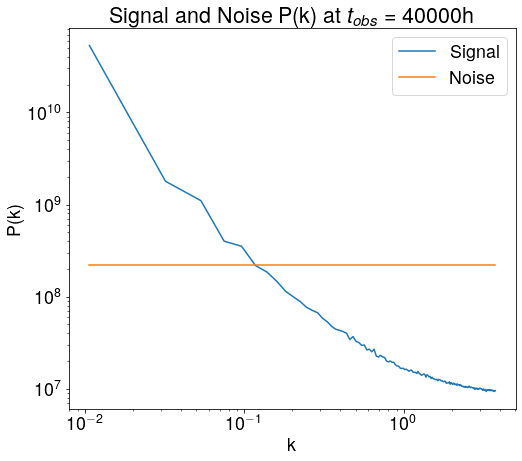

In [17]:
plt.plot(k_sim, Pk_sim, label = 'Signal')
plt.plot(k_sim, P_noise, label = 'Noise')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.title(r'Signal and Noise P(k) at $t_{obs}$ = 40000h')
plt.legend()

From `limlam_mocker.limlam_mocker.map_to_pspec()` :

In [18]:
from limlam_mocker.limlam_mocker import redshift_to_chi as rtc
from limlam_mocker.limlam_mocker import load_peakpatch_catalogue_cosmo as lppcc

x,y,z = m_cii.mapinst.pix_binedges_x, m_cii.mapinst.pix_binedges_y, m_cii.mapinst.nu_binedges
t     = mock
cosmo = lppcc(m_cii.halo_info)
zco   = rtc(m_cii.mapinst.nu_rest/z - 1, cosmo)

avg_ctd = np.mean(zco)
xco     = x/(180)*np.pi*avg_ctd
yco     = y/(180)*np.pi*avg_ctd

dxco, dyco, dzco = [np.abs(np.mean(np.diff(d))) for d in (xco, yco, zco)]
Pk_3D            = np.abs(np.fft.rfftn(t)*dxco*dyco*dzco)**2/np.abs(np.ptp(xco)*np.ptp(yco)*np.ptp(zco))

kx        = 2*np.pi*np.fft.fftfreq(xco.size - 1, d = dxco)
ky        = 2*np.pi*np.fft.fftfreq(yco.size - 1, d = dyco)
kz        = 2*np.pi*np.fft.rfftfreq(zco.size - 1, d = dzco)

kgrid     = np.sqrt(sum(ki**2 for ki in np.meshgrid(kx, ky, kz, indexing = 'ij')))
dk        = max(np.diff(kx)[0], np.diff(ky)[0], np.diff(kz)[0])

kmax_dk   = int(np.ceil(max(np.amax(kx), np.amax(ky), np.amax(kz))/dk))
kbins     = np.linspace(0, kmax_dk*dk, kmax_dk + 1)

Pk_nmodes = np.histogram(kgrid[kgrid > 0], bins = kbins, weights = Pk_3D[kgrid > 0])[0]
nmodes    = np.histogram(kgrid[kgrid > 0], bins = kbins)[0]

Pk_m = Pk_nmodes/nmodes
k_m  = (kbins[1:] + kbins[:-1])/2

Extract Wiener Filtered signal:

In [19]:
from scipy import interpolate

W_k = Pk_sim.value/(Pk_sim.value + P_noise)
interp = interpolate.interp1d(k_m, W_k, fill_value = 'extrapolate')
new_t = np.fft.rfftn(t)*interp(kgrid)
wiener_cii = np.fft.irfftn(new_t)

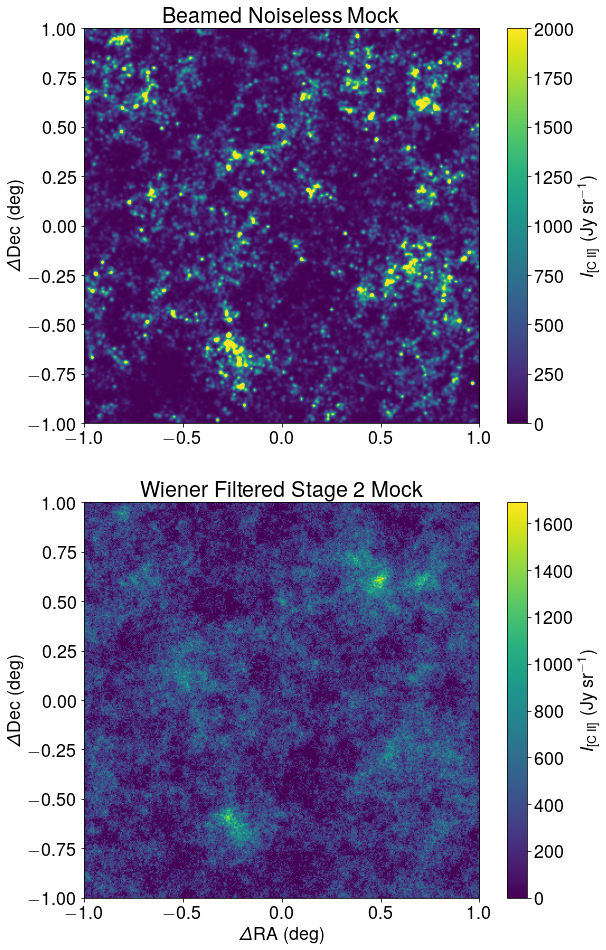

In [22]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (10, 16))

plt.subplot(211)
plt.imshow(gaussian_filter(signalsc[:, :, 6], 1), vmax = 2000, cmap =  'viridis', extent = [-1, 1, -1, 1], rasterized = True)
plt.title('Beamed Noiseless Mock')
plt.ylabel('$\\Delta$Dec (deg)')
plt.colorbar(label = '$I_{\\rm [C\\, II]}$ (Jy sr$^{-1}$)')

plt.subplot(212)
plt.imshow(wiener_cii[:, :, 6], vmin = 0, cmap =  'viridis', extent = [-1, 1, -1, 1], rasterized = True)
plt.title('Wiener Filtered Stage 2 Mock')
plt.ylabel('$\\Delta$Dec (deg)')
plt.xlabel('$\\Delta$RA (deg)')
plt.colorbar(label = '$I_{\\rm [C\\, II]}$ (Jy sr$^{-1}$)')

plt.savefig('paper_figs/corr/wf_mock.pdf', bbox_inches = 'tight', dpi = 288)

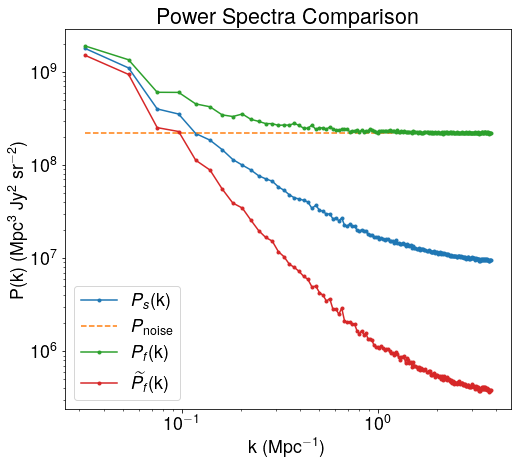

In [24]:
plt.plot(k_sim[1:], Pk_sim[1:], '.-', label = '$P_s$(k)')
plt.plot(k_sim[1:], P_noise[1:], '--', label = '$P_{\\rm{noise}}$')
plt.plot(k_sim[1:], Pk_m[1:], '.-', label = '$P_f$(k)')
plt.plot(k_sim[1:], (Pk_m*W_k**2)[1:], '.-', label = '$\\widetilde{P_f}$(k)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (Mpc$^{-1}$)')
plt.ylabel('P(k) (Mpc$^3$ Jy$^2$ sr$^{-2}$)')
plt.title('Power Spectra Comparison')
plt.legend()

plt.savefig('paper_figs/corr/pspecs.pdf', bbox_inches = 'tight')

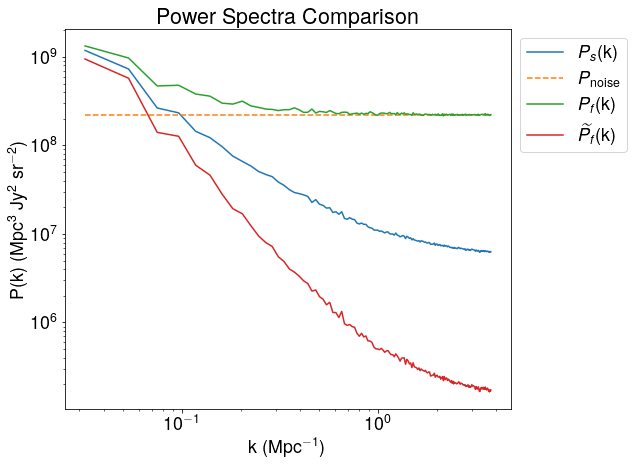

In [214]:
plt.plot(k_sim[1:], Pk_sim[1:], label = '$P_s$(k)')
plt.plot(k_sim[1:], P_noise[1:], '--', label = '$P_{\\rm{noise}}$')
plt.plot(k_sim[1:], Pk_m[1:], label = '$P_f$(k)')
plt.plot(k_sim[1:], (Pk_m*W_k**2)[1:], label = '$\\widetilde{P_f}$(k)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (Mpc$^{-1}$)')
plt.ylabel('P(k) (Mpc$^3$ Jy$^2$ sr$^{-2}$)')
plt.title('Power Spectra Comparison')
plt.legend(bbox_to_anchor = (1,1))

#plt.savefig('paper_figs/fig3_pspec_illustration/fig3_wf_pspecs.pdf', bbox_inches = 'tight')

## Working the Maps

In [9]:
sig_dnu_2_8GHz = signalsc

In [ ]:
# full lightcone
m_cii.update(model_par = {'zdex': 0.4,
                            'M0': 1900000000.0,
                            'Mmin': 20000000000,
                            'alpha_MH1': 0.74,
                            'alpha_LCII': 0.024,
                            'BehrooziFile': 'sfr_reinterp.dat',
                            'alpha0': -1.412,
                            'gamma0': 0.31},
               tobs = 40000*u.h,
               nuObs = 246*u.GHz,
               Delta_nu = 64*u.GHz,
               Omega_field = 4*(u.deg**2),
               dnu = 0.01*u.GHz,
               catalogue_file = '/home/dongwooc/scratchspace/pprun_hiz_npz/COMAP_z5.8-7.9_960Mpc_seed_13819.npz'
            )

In [10]:
sig_dnu_0_01GHz = m_cii.maps
sig_dnu_0_01GHz = sig_dnu_0_01GHz*sig_scale

Loading .npz catalogues...


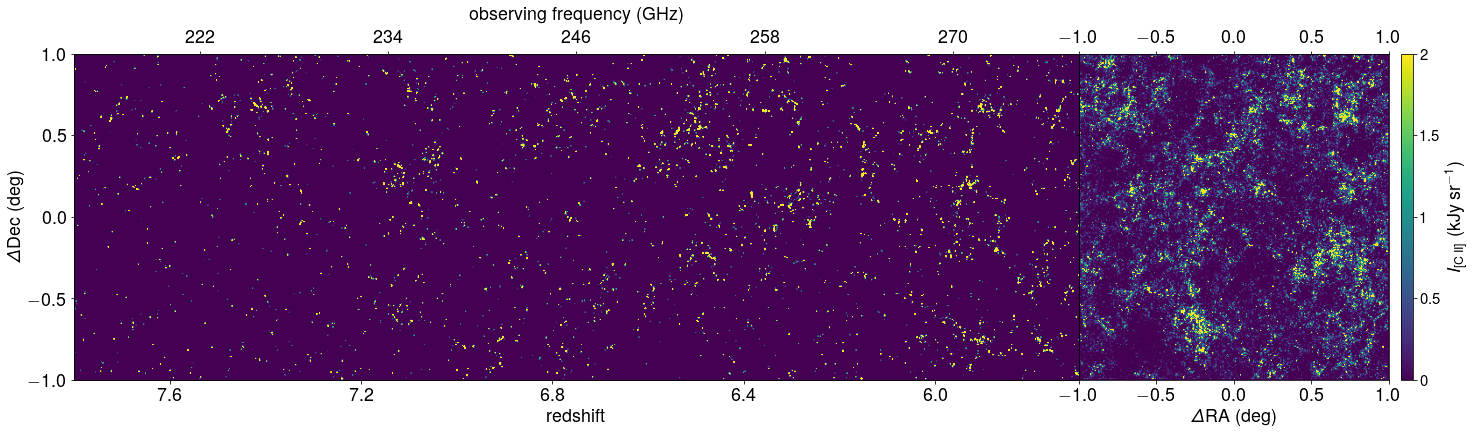

In [23]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 6), sharey = True, gridspec_kw={'wspace': 0, 'width_ratios':(3, 1)})

ax1, ax2 = ax[0], ax[0].twiny()

#ax3, ax4 = axes[1], axes[1].twiny()

# First panel: Dec/z/freq

ax[0].imshow(np.flip(sig_dnu_0_01GHz[150, :, :]), vmax = 2000, extent = [5.8, 7.9, -1, 1], aspect = 'auto', origin = 'lower')
ax[0].set_xlabel('redshift')
ax[0].set_ylabel('$\\Delta$Dec (deg)')

ax[0].set_yticks([-1, -0.5, 0, 0.5, 1])

ax1.tick_params(axis = 'x', labelbottom = True, labeltop = False)
ax1.set_xticks([6.0, 6.4, 6.8, 7.2, 7.6], labels = [7.6, 7.2, 6.8, 6.4, 6.0])

ax2.tick_params(axis = 'x', labelbottom = False, labeltop = True)
ax2.set_xticks([1/8, 5/16, 1/2, 11/16, 7/8], labels = [222, 234, 246, 258, 270])
ax2.set_xlabel('observing frequency (GHz)', labelpad = 10)

# Second panel: RA/Dec

im = ax[1].imshow(sig_dnu_2_8GHz[:, :, 6], vmax = 2000, cmap =  'viridis', extent = [-1, 1, -1, 1], aspect = 'auto')

ax[1].tick_params(axis = 'y', labelleft = False, labelright = False)

ax[1].tick_params(axis = 'x', labelbottom = True, labeltop = True)
ax[1].set_xticks([-1, -0.5, 0, 0.5, 1])
ax[1].tick_params(axis = 'x', direction = 'out', bottom = True, top = True)

ax[1].set_xlabel('$\\Delta$RA (deg)')



divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='4%', pad = '4%')
cb = fig.colorbar(im, cax = cax1)
cb.set_label(label = '$I_{\\rm [C\\, II]}$ (kJy sr$^{-1}$)')
cb.set_ticks(ticks = [0, 500, 1000, 1500, 2000], labels = ['0', '0.5', '1', '1.5', '2'], fontsize = 'small')

#plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)

plt.savefig('paper_figs/corr/radecz.pdf', bbox_inches = 'tight')